In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the directory path
data_dir = r"D:\archive (1)\PlantVillage"

# Load the entire dataset
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Define the sizes of each split
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Print class names
print(full_dataset.classes)

# Custom RegNetY600-like model definition for 64x64 images
class CustomRegNetY600(nn.Module):
    def __init__(self, num_classes=15, in_channels=3, dropout_rate=0.2):
        super(CustomRegNetY600, self).__init__()

        # Stem convolutional layer
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Blocks (similar to RegNetY's design)
        self.blocks = nn.Sequential(
            BottleneckBlock(32, 96, 3, 1, dropout_rate),
            BottleneckBlock(96, 240, 4, 2, dropout_rate),
            BottleneckBlock(240, 600, 6, 2, dropout_rate),
            BottleneckBlock(600, 1488, 8, 2, dropout_rate),
            BottleneckBlock(1488, 3552, 3, 1, dropout_rate)
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(3552, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.classifier(x)
        return x


class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, stride, dropout_rate):
        super(BottleneckBlock, self).__init__()

        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels
        
        layers.append(nn.Dropout(dropout_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Print the model architecture
model = CustomRegNetY600(num_classes=15).to(device)
print(model)



['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
CustomRegNetY600(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): BottleneckBlock(
      (block): Sequential(
        (0): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1


Training with learning rate: 0.001


Epoch [1/50], Train Loss: 2.3952, Train Accuracy: 0.2027, Val Loss: 2.3639, Val Accuracy: 0.1852


Epoch [2/50], Train Loss: 1.8939, Train Accuracy: 0.3563, Val Loss: 1.7584, Val Accuracy: 0.4198


Epoch [3/50], Train Loss: 1.8251, Train Accuracy: 0.3941, Val Loss: 1.8131, Val Accuracy: 0.3858


Epoch [4/50], Train Loss: 2.0410, Train Accuracy: 0.3317, Val Loss: 1.8574, Val Accuracy: 0.3791


Epoch [5/50], Train Loss: 1.7122, Train Accuracy: 0.4110, Val Loss: 1.7832, Val Accuracy: 0.4091


Epoch [6/50], Train Loss: 1.5720, Train Accuracy: 0.4516, Val Loss: 1.6481, Val Accuracy: 0.4358


Epoch [7/50], Train Loss: 1.3913, Train Accuracy: 0.5115, Val Loss: 1.3978, Val Accuracy: 0.5317


Epoch [8/50], Train Loss: 1.2562, Train Accuracy: 0.5720, Val Loss: 1.3915, Val Accuracy: 0.5686


Epoch [9/50], Train Loss: 1.1580, Train Accuracy: 0.6283, Val Loss: 1.1436, Val Accuracy: 0.6302


Epoch [10/50], Train Loss: 1.1002, Train Accuracy: 0.6540, Val Loss: 1.0262, Val Accuracy: 0.6621


Epoch [11/50], Train Loss: 0.9818, Train Accuracy: 0.6950, Val Loss: 1.6830, Val Accuracy: 0.6190


Epoch [12/50], Train Loss: 0.9423, Train Accuracy: 0.7154, Val Loss: 0.8755, Val Accuracy: 0.7436


Epoch [13/50], Train Loss: 0.8527, Train Accuracy: 0.7429, Val Loss: 0.9532, Val Accuracy: 0.7130


Epoch [14/50], Train Loss: 0.8192, Train Accuracy: 0.7549, Val Loss: 0.7262, Val Accuracy: 0.7756


Epoch [15/50], Train Loss: 0.8343, Train Accuracy: 0.7572, Val Loss: 1.0254, Val Accuracy: 0.6922


Epoch [16/50], Train Loss: 0.7745, Train Accuracy: 0.7741, Val Loss: 1.7054, Val Accuracy: 0.6006


Epoch [17/50], Train Loss: 0.7860, Train Accuracy: 0.7676, Val Loss: 0.6700, Val Accuracy: 0.8182


Epoch [18/50], Train Loss: 0.7364, Train Accuracy: 0.7902, Val Loss: 0.8003, Val Accuracy: 0.7533


Epoch [19/50], Train Loss: 0.6978, Train Accuracy: 0.8024, Val Loss: 0.9621, Val Accuracy: 0.7310


Epoch [20/50], Train Loss: 0.5795, Train Accuracy: 0.8350, Val Loss: 0.6490, Val Accuracy: 0.8216


Epoch [21/50], Train Loss: 0.5291, Train Accuracy: 0.8529, Val Loss: 0.5454, Val Accuracy: 0.8386


Epoch [22/50], Train Loss: 0.4498, Train Accuracy: 0.8751, Val Loss: 0.4922, Val Accuracy: 0.8638


Epoch [23/50], Train Loss: 0.3898, Train Accuracy: 0.8921, Val Loss: 0.6481, Val Accuracy: 0.8376


Epoch [24/50], Train Loss: 0.3891, Train Accuracy: 0.8932, Val Loss: 0.5426, Val Accuracy: 0.8362


Epoch [25/50], Train Loss: 0.3230, Train Accuracy: 0.9113, Val Loss: 0.5419, Val Accuracy: 0.8362


Epoch [26/50], Train Loss: 0.2989, Train Accuracy: 0.9177, Val Loss: 0.3047, Val Accuracy: 0.9190


Epoch [27/50], Train Loss: 0.2932, Train Accuracy: 0.9192, Val Loss: 0.3512, Val Accuracy: 0.8968


Epoch [28/50], Train Loss: 0.3247, Train Accuracy: 0.9111, Val Loss: 1.6496, Val Accuracy: 0.8328


Epoch [29/50], Train Loss: 0.4151, Train Accuracy: 0.8924, Val Loss: 0.2935, Val Accuracy: 0.9113


Epoch [30/50], Train Loss: 0.2785, Train Accuracy: 0.9253, Val Loss: 0.3733, Val Accuracy: 0.9035


Epoch [31/50], Train Loss: 0.2521, Train Accuracy: 0.9322, Val Loss: 0.3206, Val Accuracy: 0.9118


Epoch [32/50], Train Loss: 0.2041, Train Accuracy: 0.9438, Val Loss: 0.3134, Val Accuracy: 0.9176


Epoch [33/50], Train Loss: 0.2042, Train Accuracy: 0.9439, Val Loss: 0.2324, Val Accuracy: 0.9326


Epoch [34/50], Train Loss: 0.1877, Train Accuracy: 0.9490, Val Loss: 0.3882, Val Accuracy: 0.9040


Epoch [35/50], Train Loss: 0.1871, Train Accuracy: 0.9507, Val Loss: 0.3099, Val Accuracy: 0.9181


Epoch [36/50], Train Loss: 0.1572, Train Accuracy: 0.9603, Val Loss: 0.2658, Val Accuracy: 0.9297


Epoch [37/50], Train Loss: 0.1614, Train Accuracy: 0.9584, Val Loss: 0.3683, Val Accuracy: 0.9040


Epoch [38/50], Train Loss: 0.1534, Train Accuracy: 0.9584, Val Loss: 0.3216, Val Accuracy: 0.9254


Epoch [39/50], Train Loss: 0.1540, Train Accuracy: 0.9594, Val Loss: 0.3013, Val Accuracy: 0.9302


Epoch [40/50], Train Loss: 0.1270, Train Accuracy: 0.9666, Val Loss: 0.4300, Val Accuracy: 0.9064


Epoch [41/50], Train Loss: 0.1375, Train Accuracy: 0.9644, Val Loss: 0.2965, Val Accuracy: 0.9370


Epoch [42/50], Train Loss: 0.1462, Train Accuracy: 0.9641, Val Loss: 0.3903, Val Accuracy: 0.8963


Epoch [43/50], Train Loss: 0.1520, Train Accuracy: 0.9625, Val Loss: 0.3073, Val Accuracy: 0.9302


Epoch [44/50], Train Loss: 0.1164, Train Accuracy: 0.9697, Val Loss: 0.3035, Val Accuracy: 0.9375


Epoch [45/50], Train Loss: 0.1132, Train Accuracy: 0.9720, Val Loss: 0.2733, Val Accuracy: 0.9360


Epoch [46/50], Train Loss: 0.1074, Train Accuracy: 0.9746, Val Loss: 0.3708, Val Accuracy: 0.9108


Epoch [47/50], Train Loss: 0.1015, Train Accuracy: 0.9741, Val Loss: 0.3081, Val Accuracy: 0.9302


Epoch [48/50], Train Loss: 0.1102, Train Accuracy: 0.9732, Val Loss: 0.3050, Val Accuracy: 0.9249


Epoch [49/50], Train Loss: 0.0982, Train Accuracy: 0.9755, Val Loss: 0.2701, Val Accuracy: 0.9399


Epoch [50/50], Train Loss: 0.0868, Train Accuracy: 0.9783, Val Loss: 0.2430, Val Accuracy: 0.9438
Test Loss: 0.2298, Test Accuracy: 0.9419

Training with learning rate: 0.0001


Epoch [1/50], Train Loss: 2.0513, Train Accuracy: 0.3336, Val Loss: 1.5547, Val Accuracy: 0.5201


Epoch [2/50], Train Loss: 1.2504, Train Accuracy: 0.5931, Val Loss: 0.9555, Val Accuracy: 0.6927


Epoch [3/50], Train Loss: 0.8679, Train Accuracy: 0.7240, Val Loss: 0.6734, Val Accuracy: 0.7853


Epoch [4/50], Train Loss: 0.6139, Train Accuracy: 0.8016, Val Loss: 0.6268, Val Accuracy: 0.8110


Epoch [5/50], Train Loss: 0.5095, Train Accuracy: 0.8435, Val Loss: 0.4636, Val Accuracy: 0.8609


Epoch [6/50], Train Loss: 0.4158, Train Accuracy: 0.8718, Val Loss: 0.7056, Val Accuracy: 0.8143


Epoch [7/50], Train Loss: 0.3545, Train Accuracy: 0.8931, Val Loss: 0.3788, Val Accuracy: 0.8929


Epoch [8/50], Train Loss: 0.3084, Train Accuracy: 0.9082, Val Loss: 0.3908, Val Accuracy: 0.8924


Epoch [9/50], Train Loss: 0.2663, Train Accuracy: 0.9211, Val Loss: 0.3642, Val Accuracy: 0.9001


Epoch [10/50], Train Loss: 0.2376, Train Accuracy: 0.9317, Val Loss: 0.3204, Val Accuracy: 0.9016


Epoch [11/50], Train Loss: 0.2287, Train Accuracy: 0.9348, Val Loss: 0.2960, Val Accuracy: 0.9171


Epoch [12/50], Train Loss: 0.2175, Train Accuracy: 0.9382, Val Loss: 0.2731, Val Accuracy: 0.9249


Epoch [13/50], Train Loss: 0.1852, Train Accuracy: 0.9477, Val Loss: 0.2925, Val Accuracy: 0.9229


Epoch [14/50], Train Loss: 0.1617, Train Accuracy: 0.9566, Val Loss: 0.2905, Val Accuracy: 0.9147


Epoch [15/50], Train Loss: 0.1652, Train Accuracy: 0.9560, Val Loss: 0.2872, Val Accuracy: 0.9297


Epoch [16/50], Train Loss: 0.1510, Train Accuracy: 0.9597, Val Loss: 0.3297, Val Accuracy: 0.9171


Epoch [17/50], Train Loss: 0.1581, Train Accuracy: 0.9554, Val Loss: 0.2765, Val Accuracy: 0.9326


Epoch [18/50], Train Loss: 0.1420, Train Accuracy: 0.9612, Val Loss: 0.3102, Val Accuracy: 0.9205


Epoch [19/50], Train Loss: 0.1340, Train Accuracy: 0.9632, Val Loss: 0.2770, Val Accuracy: 0.9326


Epoch [20/50], Train Loss: 0.1249, Train Accuracy: 0.9632, Val Loss: 0.2940, Val Accuracy: 0.9258


Epoch [21/50], Train Loss: 0.1186, Train Accuracy: 0.9681, Val Loss: 0.2568, Val Accuracy: 0.9341


Epoch [22/50], Train Loss: 0.1168, Train Accuracy: 0.9669, Val Loss: 0.2856, Val Accuracy: 0.9346


Epoch [23/50], Train Loss: 0.1072, Train Accuracy: 0.9713, Val Loss: 0.2375, Val Accuracy: 0.9394


Epoch [24/50], Train Loss: 0.0906, Train Accuracy: 0.9757, Val Loss: 0.4262, Val Accuracy: 0.8914


Epoch [25/50], Train Loss: 0.1024, Train Accuracy: 0.9727, Val Loss: 0.2264, Val Accuracy: 0.9321


Epoch [26/50], Train Loss: 0.1026, Train Accuracy: 0.9711, Val Loss: 0.2893, Val Accuracy: 0.9239


Epoch [27/50], Train Loss: 0.1023, Train Accuracy: 0.9735, Val Loss: 0.2890, Val Accuracy: 0.9297


Epoch [28/50], Train Loss: 0.0848, Train Accuracy: 0.9802, Val Loss: 0.4978, Val Accuracy: 0.9031


Epoch [29/50], Train Loss: 0.1005, Train Accuracy: 0.9734, Val Loss: 0.4211, Val Accuracy: 0.9215


Epoch [30/50], Train Loss: 0.0893, Train Accuracy: 0.9775, Val Loss: 0.2262, Val Accuracy: 0.9399


Epoch [31/50], Train Loss: 0.0869, Train Accuracy: 0.9761, Val Loss: 0.2604, Val Accuracy: 0.9370


Epoch [32/50], Train Loss: 0.0945, Train Accuracy: 0.9764, Val Loss: 0.2475, Val Accuracy: 0.9350


Epoch [33/50], Train Loss: 0.0895, Train Accuracy: 0.9768, Val Loss: 0.2676, Val Accuracy: 0.9365


Epoch [34/50], Train Loss: 0.0750, Train Accuracy: 0.9808, Val Loss: 0.3464, Val Accuracy: 0.9254


Epoch [35/50], Train Loss: 0.0956, Train Accuracy: 0.9753, Val Loss: 0.4136, Val Accuracy: 0.9084


Epoch [36/50], Train Loss: 0.0769, Train Accuracy: 0.9808, Val Loss: 0.2290, Val Accuracy: 0.9428


Epoch [37/50], Train Loss: 0.0812, Train Accuracy: 0.9793, Val Loss: 0.2506, Val Accuracy: 0.9384


Epoch [38/50], Train Loss: 0.0766, Train Accuracy: 0.9811, Val Loss: 0.2138, Val Accuracy: 0.9443


Epoch [39/50], Train Loss: 0.0582, Train Accuracy: 0.9853, Val Loss: 0.2268, Val Accuracy: 0.9467


Epoch [40/50], Train Loss: 0.0822, Train Accuracy: 0.9791, Val Loss: 0.2756, Val Accuracy: 0.9350


Epoch [41/50], Train Loss: 0.0693, Train Accuracy: 0.9835, Val Loss: 0.3169, Val Accuracy: 0.9244


Epoch [42/50], Train Loss: 0.0525, Train Accuracy: 0.9878, Val Loss: 0.2388, Val Accuracy: 0.9481


Epoch [43/50], Train Loss: 0.0731, Train Accuracy: 0.9819, Val Loss: 0.2908, Val Accuracy: 0.9292


Epoch [44/50], Train Loss: 0.0665, Train Accuracy: 0.9835, Val Loss: 0.2357, Val Accuracy: 0.9404


Epoch [45/50], Train Loss: 0.0702, Train Accuracy: 0.9836, Val Loss: 0.2331, Val Accuracy: 0.9491


Epoch [46/50], Train Loss: 0.0543, Train Accuracy: 0.9874, Val Loss: 0.2470, Val Accuracy: 0.9501


Epoch [47/50], Train Loss: 0.0572, Train Accuracy: 0.9855, Val Loss: 0.2959, Val Accuracy: 0.9389


Epoch [48/50], Train Loss: 0.0586, Train Accuracy: 0.9855, Val Loss: 0.2544, Val Accuracy: 0.9447


Epoch [49/50], Train Loss: 0.0646, Train Accuracy: 0.9846, Val Loss: 0.2694, Val Accuracy: 0.9413


Epoch [50/50], Train Loss: 0.0679, Train Accuracy: 0.9835, Val Loss: 0.2212, Val Accuracy: 0.9515
Test Loss: 0.1870, Test Accuracy: 0.9521

Training with learning rate: 1e-05


Epoch [1/50], Train Loss: 2.5291, Train Accuracy: 0.1715, Val Loss: 2.9772, Val Accuracy: 0.1105


Epoch [2/50], Train Loss: 2.4111, Train Accuracy: 0.2065, Val Loss: 3.1171, Val Accuracy: 0.0761


Epoch [3/50], Train Loss: 2.3407, Train Accuracy: 0.2324, Val Loss: 3.2989, Val Accuracy: 0.0926


Epoch [4/50], Train Loss: 2.2473, Train Accuracy: 0.2564, Val Loss: 2.9999, Val Accuracy: 0.1474


Epoch [5/50], Train Loss: 2.1506, Train Accuracy: 0.2866, Val Loss: 2.8529, Val Accuracy: 0.1953


Epoch [6/50], Train Loss: 2.0499, Train Accuracy: 0.3307, Val Loss: 2.5770, Val Accuracy: 0.2458


Epoch [7/50], Train Loss: 1.9443, Train Accuracy: 0.3581, Val Loss: 2.5391, Val Accuracy: 0.2632


Epoch [8/50], Train Loss: 1.8479, Train Accuracy: 0.3928, Val Loss: 2.2265, Val Accuracy: 0.3345


Epoch [9/50], Train Loss: 1.7327, Train Accuracy: 0.4268, Val Loss: 2.0057, Val Accuracy: 0.3800


Epoch [10/50], Train Loss: 1.6477, Train Accuracy: 0.4584, Val Loss: 1.9238, Val Accuracy: 0.4096


Epoch [11/50], Train Loss: 1.5444, Train Accuracy: 0.4904, Val Loss: 1.7937, Val Accuracy: 0.4464


Epoch [12/50], Train Loss: 1.4503, Train Accuracy: 0.5210, Val Loss: 1.6736, Val Accuracy: 0.4842


Epoch [13/50], Train Loss: 1.3550, Train Accuracy: 0.5477, Val Loss: 1.5701, Val Accuracy: 0.5065


Epoch [14/50], Train Loss: 1.2773, Train Accuracy: 0.5701, Val Loss: 1.4539, Val Accuracy: 0.5531


Epoch [15/50], Train Loss: 1.1931, Train Accuracy: 0.6027, Val Loss: 1.3028, Val Accuracy: 0.5885


Epoch [16/50], Train Loss: 1.1396, Train Accuracy: 0.6151, Val Loss: 1.2900, Val Accuracy: 0.5982


Epoch [17/50], Train Loss: 1.0618, Train Accuracy: 0.6405, Val Loss: 1.2174, Val Accuracy: 0.6093


Epoch [18/50], Train Loss: 1.0076, Train Accuracy: 0.6608, Val Loss: 1.1488, Val Accuracy: 0.6253


Epoch [19/50], Train Loss: 0.9306, Train Accuracy: 0.6860, Val Loss: 1.0691, Val Accuracy: 0.6554


Epoch [20/50], Train Loss: 0.8690, Train Accuracy: 0.7078, Val Loss: 1.0033, Val Accuracy: 0.6825


Epoch [21/50], Train Loss: 0.8043, Train Accuracy: 0.7230, Val Loss: 0.9949, Val Accuracy: 0.6941


Epoch [22/50], Train Loss: 0.7359, Train Accuracy: 0.7487, Val Loss: 0.9263, Val Accuracy: 0.7106


Epoch [23/50], Train Loss: 0.6897, Train Accuracy: 0.7657, Val Loss: 0.8431, Val Accuracy: 0.7387


Epoch [24/50], Train Loss: 0.6407, Train Accuracy: 0.7799, Val Loss: 0.7761, Val Accuracy: 0.7557


Epoch [25/50], Train Loss: 0.5933, Train Accuracy: 0.7955, Val Loss: 0.8248, Val Accuracy: 0.7562


Epoch [26/50], Train Loss: 0.5439, Train Accuracy: 0.8150, Val Loss: 0.7641, Val Accuracy: 0.7761


Epoch [27/50], Train Loss: 0.5067, Train Accuracy: 0.8242, Val Loss: 0.6912, Val Accuracy: 0.7872


Epoch [28/50], Train Loss: 0.4674, Train Accuracy: 0.8417, Val Loss: 0.6856, Val Accuracy: 0.7974


Epoch [29/50], Train Loss: 0.4438, Train Accuracy: 0.8492, Val Loss: 0.5924, Val Accuracy: 0.8216


Epoch [30/50], Train Loss: 0.4155, Train Accuracy: 0.8590, Val Loss: 0.5858, Val Accuracy: 0.8245


Epoch [31/50], Train Loss: 0.3795, Train Accuracy: 0.8706, Val Loss: 0.5792, Val Accuracy: 0.8371


Epoch [32/50], Train Loss: 0.3650, Train Accuracy: 0.8720, Val Loss: 0.5439, Val Accuracy: 0.8425


Epoch [33/50], Train Loss: 0.3411, Train Accuracy: 0.8840, Val Loss: 0.5339, Val Accuracy: 0.8429


Epoch [34/50], Train Loss: 0.3140, Train Accuracy: 0.8935, Val Loss: 0.5307, Val Accuracy: 0.8531


Epoch [35/50], Train Loss: 0.2928, Train Accuracy: 0.8992, Val Loss: 0.5222, Val Accuracy: 0.8483


Epoch [36/50], Train Loss: 0.2720, Train Accuracy: 0.9067, Val Loss: 0.5486, Val Accuracy: 0.8434


Epoch [37/50], Train Loss: 0.2658, Train Accuracy: 0.9092, Val Loss: 0.5152, Val Accuracy: 0.8570


Epoch [38/50], Train Loss: 0.2551, Train Accuracy: 0.9147, Val Loss: 0.4816, Val Accuracy: 0.8662


Epoch [39/50], Train Loss: 0.2335, Train Accuracy: 0.9204, Val Loss: 0.4621, Val Accuracy: 0.8711


Epoch [40/50], Train Loss: 0.2184, Train Accuracy: 0.9253, Val Loss: 0.4691, Val Accuracy: 0.8730


Epoch [41/50], Train Loss: 0.1987, Train Accuracy: 0.9321, Val Loss: 0.4786, Val Accuracy: 0.8677


Epoch [42/50], Train Loss: 0.1980, Train Accuracy: 0.9326, Val Loss: 0.4472, Val Accuracy: 0.8793


Epoch [43/50], Train Loss: 0.1898, Train Accuracy: 0.9353, Val Loss: 0.4735, Val Accuracy: 0.8774


Epoch [44/50], Train Loss: 0.1766, Train Accuracy: 0.9399, Val Loss: 0.4268, Val Accuracy: 0.8909


Epoch [45/50], Train Loss: 0.1743, Train Accuracy: 0.9393, Val Loss: 0.4575, Val Accuracy: 0.8900


Epoch [46/50], Train Loss: 0.1614, Train Accuracy: 0.9435, Val Loss: 0.4337, Val Accuracy: 0.8866


Epoch [47/50], Train Loss: 0.1539, Train Accuracy: 0.9483, Val Loss: 0.4058, Val Accuracy: 0.8919


Epoch [48/50], Train Loss: 0.1416, Train Accuracy: 0.9527, Val Loss: 0.4243, Val Accuracy: 0.8856


Epoch [49/50], Train Loss: 0.1331, Train Accuracy: 0.9555, Val Loss: 0.4238, Val Accuracy: 0.8885


Epoch [50/50], Train Loss: 0.1355, Train Accuracy: 0.9538, Val Loss: 0.4275, Val Accuracy: 0.8905
Test Loss: 0.4119, Test Accuracy: 0.8828


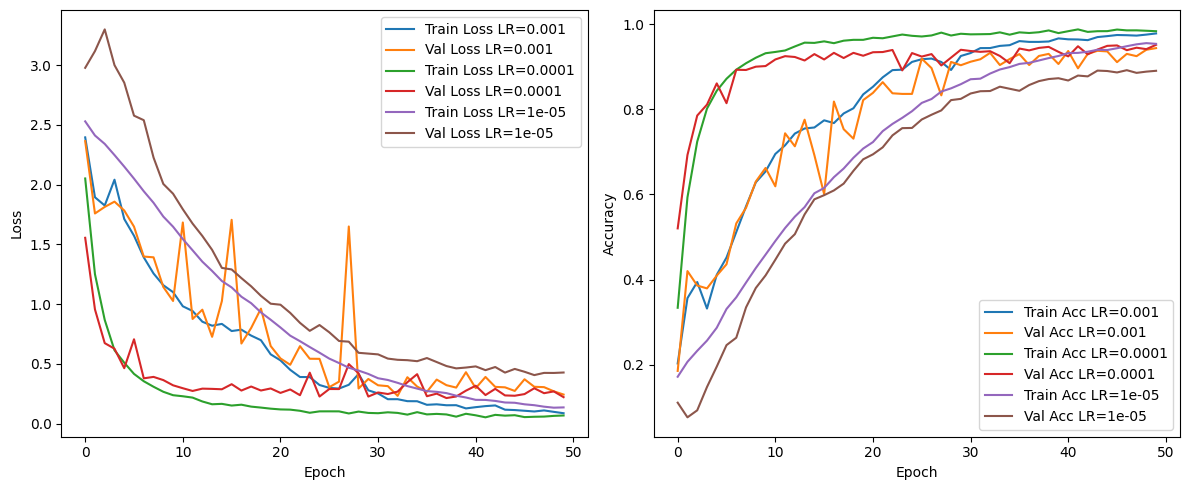

In [2]:

# Define the evaluation function
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Define the training and evaluation function
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, num_epochs, lr, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Define the learning rates to evaluate
learning_rates = [1e-3, 1e-4, 1e-5]

# Initialize the model and criterion
model = CustomRegNetY600(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()

# Loop through learning rates
results = {}
for lr in learning_rates:
    print(f'\nTraining with learning rate: {lr}')
    model = CustomRegNetY600(num_classes=15).to(device)
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, num_epochs=50, lr=lr, device=device)
    results[lr] = (train_losses, val_losses, train_accuracies, val_accuracies)

# Plot the results
plt.figure(figsize=(12, 5))

for lr, (train_losses, val_losses, train_accuracies, val_accuracies) in results.items():
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss LR={lr}')
    plt.plot(val_losses, label=f'Val Loss LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Acc LR={lr}')
    plt.plot(val_accuracies, label=f'Val Acc LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()
